# West Nile Analysis

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier,  AdaBoostClassifier
from sklearn.cross_validation import train_test_split, KFold, cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns



In [41]:
train = pd.read_csv('../data/trainw.csv')
test  = pd.read_csv('../data/testw.csv')
train.columns = [col.lower().replace(' ', '_') for col in train.columns]
test.columns = [col.lower().replace(' ', '_') for col in test.columns]


#read cleaned data and bring and trainform all variables to lower_camel_case
                    

In [42]:
train.isnull().sum() 


unnamed:_0                             0
index                                  0
date                                   0
address                                0
block                                  0
street                                 0
trap                                   0
addressnumberandstreet                 0
latitude                               0
longitude                              0
addressaccuracy                        0
nummosquitos                           0
wnvpresent                             0
year                                   0
month                                  0
day                                    0
tmax_x                                 0
tmin_x                                 0
tavg_x                                 0
depart_x                               0
dewpoint_x                             0
wetbulb_x                              0
heat_x                                 0
cool_x                                 0
sunrise_x       

In [43]:
train.columns[50:70]

Index(['preciptotal_y', 'stnpressure_y', 'sealevel_y', 'resultspeed_y',
       'resultdir_y', 'avgspeed_y', 'temp_min_both', 'temp_max_both',
       'temp_avg_both', 'temp_dew_point_both', 'temp_wet_bulb_both',
       'stnpressure_both', 'ht_cool_both', 'temp_min_both1', 'temp_min_both2',
       'temp_min_both4', 'temp_min_both7', 'temp_min_both10',
       'temp_min_both14', 'temp_max_both1'],
      dtype='object')

In [44]:
train['month_year'] = train['month'] * (train['year'] - 2007)
test['month_year'] = test['month'] * (test['year'] - 2007)

In [45]:
#included features to set up X and Y from training set
# features = [ 'trap', 'block', 'month', 'street', 'tmax_y', 
#             'tavg_y', 'dewpoint_y',
#             'preciptotal_y', 'stnpressure_y',
#             'sealevel_y', 'resultspeed_y', 'resultdir_y', 'avgspeed_y', 'distance',
#             'dist_species_culex_pipiens',
#             'dist_species_culex_pipiens/restuans', 'dist_species_culex_restuans',
#             'dist_species_culex_salinarius', 
#             'dist_species_culex_territans',
#             'month_dist_temp_y',
#             'month_and_dist', 'distance_3','distance_5'
            
#            ]

#Found by running ada boost feature importance-these had a score above 0
features=[  'distance', 'year', 'month_year',
       'latitude', 'sunrise_x', 'distance_5', 
       'resultspeed_y', 'trap', 'street', 'trap_and_temp_x',
       'dist_species_culex_pipiens/restuans', 
       'sealevel_x', 'longitude', 'block_and_precip_x',
       'species_culex_territans', 'dist_species_culex_pipiens',
       'depart_x',  'tmin_x', 
       'month_dist_3_temp_x','month_dist_5_temp_x',
       'temp_min_both', 'temp_max_both',
       'temp_avg_both', 'temp_dew_point_both', 'temp_wet_bulb_both',
       'stnpressure_both', 'ht_cool_both', 'temp_min_both1', 'temp_min_both2',
       'temp_min_both4', 'temp_min_both7', 'temp_min_both10',
       'temp_min_both14', 'temp_max_both1'
       ]




X = train[features]
y = train['wnvpresent']

In [46]:
#do a train test split with stratified data due to unbalanced classes

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    random_state = 42,
                                                    stratify = y)

#### Dealing with unbalanced classes

We have unbalanced classes in our data set with only about 5.24% of our observations containing the West Nile Virus.  In order to better predict the minority class which is the class of interest we are oversampling the data where West Nile is present in our training data.  We leave the testing data untouched.

In [47]:
#merging the target variable back onto the training data in order to sample off its value

datasets = (X_train, y_train)
traincombined = pd.concat(datasets, axis = 1)
traincombined.head()

,distance,year,month_year,latitude,sunrise_x,distance_5,resultspeed_y,trap,street,trap_and_temp_x,...,stnpressure_both,ht_cool_both,temp_min_both1,temp_min_both2,temp_min_both4,temp_min_both7,temp_min_both10,temp_min_both14,temp_max_both1,wnvpresent
70,0.680102,2007.0,0.0,41.958271,417,1.679011,6.2,90,41,5760,...,29.130,17.0,57,57,57,57,49,49,71,0.0
7447,2.384295,2013.0,48.0,41.957799,445,2.384295,6.2,134,131,10854,...,29.260,-13.0,63,59,54,54,54,54,75,0.0
4240,2.384295,2009.0,16.0,41.957799,512,6.970312,10.7,134,131,8978,...,29.385,1.0,63,60,55,55,55,55,72,0.0
8059,1.387414,2013.0,54.0,41.801498,522,1.726628,4.3,22,58,1892,...,29.410,-16.0,62,59,57,57,57,57,74,0.0
8309,0.939177,2013.0,54.0,41.916265,536,0.939177,7.8,95,0,7980,...,29.175,-24.0,61,51,51,49,49,49,81,0.0


In [48]:
#Select West nile cases and generate 5000 samples
west_nile = traincombined[traincombined.wnvpresent == 1]
extra_west_nile = west_nile.sample(n = 4000, 
                                   replace = True,
                                   random_state = 30,
                                   axis = 0)

In [49]:
#merge samples onto original data
merge = [traincombined, extra_west_nile]
trainmerged = pd.concat(merge, axis = 0)

In [50]:
#Break our training data back into a X and a y
X_train = trainmerged[features]
y_train = trainmerged['wnvpresent']

### Set up our model for grid search evaluation

In [52]:
ad = AdaBoostClassifier()
sd_params = {
    'n_estimators'       : [ 150, 200, 300],
    'learning_rate'          : [.3, .5, .7]
   }



In [53]:
gs = GridSearchCV(ad, 
                  param_grid=sd_params,
                 scoring = 'recall',
                  cv = 4)


In [54]:
gs.fit(X_train, y_train)
print("Print Train Score : " , gs.best_score_)
print("Print Test Score  : " , gs.score(X_test, y_test))
print("Print Best Params : " , gs.best_params_)

Print Train Score :  0.8735091773405986
Print Test Score  :  0.6881720430107527
Print Best Params :  {'learning_rate': 0.7, 'n_estimators': 300}


In [18]:
y_hat = gs.predict(X_test)
y_hat_train = gs.predict(X_train)
y_hat_prob = gs.predict_proba(X_test)


In [19]:
ad1= AdaBoostClassifier(n_estimators= 150, learning_rate=.3)
ad1.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=150, random_state=None)

In [20]:
ad1.feature_importances_

array([0.04666667, 0.00666667, 0.01333333, 0.07333333, 0.12      ,
       0.10666667, 0.02666667, 0.00666667, 0.04      , 0.05333333,
       0.06      , 0.02      , 0.07333333, 0.01333333, 0.00666667,
       0.05333333, 0.        , 0.00666667, 0.03333333, 0.10666667,
       0.03333333, 0.02666667, 0.00666667, 0.        , 0.01333333,
       0.01333333, 0.00666667, 0.00666667, 0.        , 0.00666667,
       0.        , 0.        , 0.02      , 0.        ])

In [21]:
# View Feature Importance from ADA Boost model
raw_data={'ADA Imp':ad1.feature_importances_}
ada2_df=pd.DataFrame(raw_data,train[features].columns)
ada2_df=ada2_df.sort_values('ADA Imp', ascending=False) 
ada2_df

,ADA Imp
sunrise_x,0.120000
distance_5,0.106667
month_dist_5_temp_x,0.106667
latitude,0.073333
longitude,0.073333
dist_species_culex_pipiens/restuans,0.060000
dist_species_culex_pipiens,0.053333
trap_and_temp_x,0.053333
distance,0.046667
street,0.040000


In [22]:
ada2_df=ada2_df.loc[ada2_df['ADA Imp'] != 0]
ada2_df.loc[ada2_df['ADA Imp'] != 0]

,ADA Imp
sunrise_x,0.120000
distance_5,0.106667
month_dist_5_temp_x,0.106667
latitude,0.073333
longitude,0.073333
dist_species_culex_pipiens/restuans,0.060000
dist_species_culex_pipiens,0.053333
trap_and_temp_x,0.053333
distance,0.046667
street,0.040000


In [23]:
print(classification_report( y_train, y_hat_train))

             precision    recall  f1-score   support

        0.0       0.88      0.82      0.85      6079
        1.0       0.76      0.84      0.80      4277

avg / total       0.83      0.83      0.83     10356



In [24]:
print(classification_report(y_test, y_hat))

             precision    recall  f1-score   support

        0.0       0.99      0.82      0.90      2026
        1.0       0.16      0.75      0.27        93

avg / total       0.95      0.82      0.87      2119



In [25]:
confusion_matrix(y_train, y_hat_train)

array([[4978, 1101],
       [ 698, 3579]])

In [26]:
confusion_matrix(y_test, y_hat)

array([[1662,  364],
       [  23,   70]])

In [27]:
y_test.value_counts()

0.0    2026
1.0      93
Name: wnvpresent, dtype: int64

In [28]:
X = test[features]
predict = (gs.predict(X))
predprob = gs.predict_proba(X)

In [29]:
predprob

array([[0.55743167, 0.44256833],
       [0.55861947, 0.44138053],
       [0.55674117, 0.44325883],
       ...,
       [0.50641452, 0.49358548],
       [0.50641452, 0.49358548],
       [0.50641452, 0.49358548]])

In [30]:
y_train_pred_proba = gs.predict_proba(X_train)
y_train_pred = gs.predict(X_train)
y_test_pred_proba = gs.predict_proba(X_test)
y_test_pred = gs.predict(X_test)

In [31]:
#modifying train and testing data to allow for changing prob thresholds and printing the 
#roc curves
X_train.loc[:, 'actual_y'] = y_train
X_train.loc[:, 'predicted_label'] = y_train_pred
X_train.loc[:, 'predicted_proba'] = y_train_pred_proba[:, 1]


In [32]:
X_test.loc[:, 'actual_y'] = y_test
X_test.loc[:, 'predicted_label'] = y_test_pred
X_test.loc[:, 'predicted_proba'] = y_test_pred_proba[:, 1]


In [33]:
mask_misclassification = (X_test[X_test['predicted_label'] == 0])
misclassifications = (mask_misclassification[mask_misclassification['actual_y'] == 1])
misclassifications_df = pd.DataFrame(misclassifications)

In [34]:
misclassifications_df.to_csv('../data/misclassifications.csv', index = False)

In [35]:
#print out confusion matrices from .1 .5 by .02 for Xtest and Xtrain
for prob in range(490, 500, 1):
    proba = prob/1000
    
    X_test.loc[:, 'predicted_label']= X_test['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_train.loc[:, 'predicted_label']= X_train['predicted_proba'].map(
    lambda p: 1 if p > proba else 0)
    
    X_test['predicted_label']
    print('Test  ' + str(proba))
    print(confusion_matrix(y_test, X_test['predicted_label']))
    print(' Train  ' + str(proba))
    print(confusion_matrix(y_train, X_train['predicted_label']))


Test  0.49
[[ 784 1242]
 [   1   92]]
 Train  0.49
[[2322 3757]
 [   0 4277]]
Test  0.491
[[ 830 1196]
 [   1   92]]
 Train  0.491
[[2464 3615]
 [   0 4277]]
Test  0.492
[[ 883 1143]
 [   3   90]]
 Train  0.492
[[2634 3445]
 [   0 4277]]
Test  0.493
[[ 950 1076]
 [   3   90]]
 Train  0.493
[[2823 3256]
 [   0 4277]]
Test  0.494
[[1017 1009]
 [   4   89]]
 Train  0.494
[[3045 3034]
 [   0 4277]]
Test  0.495
[[1100  926]
 [   5   88]]
 Train  0.495
[[3302 2777]
 [   0 4277]]
Test  0.496
[[1204  822]
 [   7   86]]
 Train  0.496
[[3651 2428]
 [  30 4247]]
Test  0.497
[[1336  690]
 [  11   82]]
 Train  0.497
[[4002 2077]
 [  41 4236]]
Test  0.498
[[1447  579]
 [  13   80]]
 Train  0.498
[[4322 1757]
 [ 203 4074]]
Test  0.499
[[1550  476]
 [  19   74]]
 Train  0.499
[[4630 1449]
 [ 374 3903]]


In [36]:
fpr, tpr, _ = roc_curve(y_train, X_train['predicted_proba'])
roc_auc = auc(fpr, tpr)


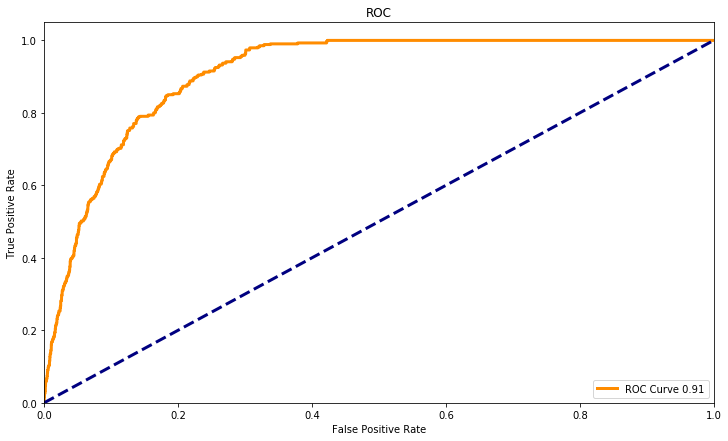

In [37]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [38]:
fpr, tpr, _ = roc_curve(y_test, X_test['predicted_proba'])
roc_auc = auc(fpr, tpr)

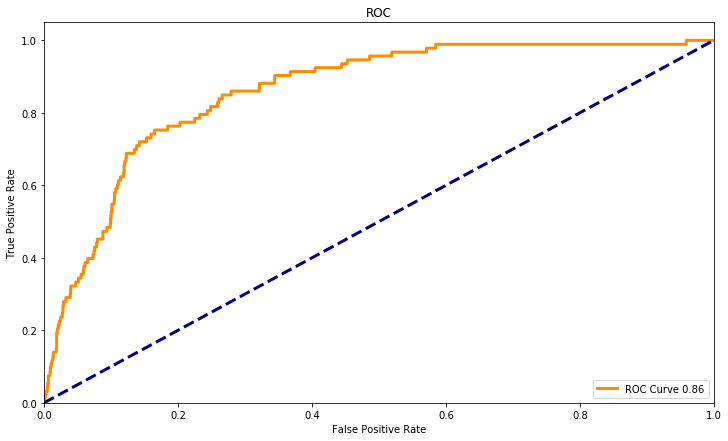

In [39]:
# Plot 
plt.figure(figsize = (12,7))
line_width = 3

plt.plot(fpr, tpr, lw = line_width, color="darkorange", label = "ROC Curve %.2f" % roc_auc)
plt.plot([0,1], [0, 1], lw = line_width, linestyle="--", color="navy")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [292]:
ada_predict = gs.predict(X)
ada_proba = gs.predict_proba(X)[:,1]

In [293]:
ada_proba

array([0.44295424, 0.44166008, 0.44379114, ..., 0.49663041, 0.49663041,
       0.49663041])

In [334]:
submissions = pd.DataFrame(ada_predict, columns = ['wnvpresent'])
submissions['predproba'] = ada_proba
submissions.loc[:, 'wnvpresent']= submissions['predproba'].map(
    lambda p: 1 if p > .499999
    else 0)

In [335]:
submissions.wnvpresent.value_counts()

0    107236
1      9057
Name: wnvpresent, dtype: int64

In [312]:
X.shape

(116293, 20)

In [313]:
submissions['id'] = [id +1 for id in range(len(submissions))]

In [314]:
submissions = submissions[['id','wnvpresent' ]]


In [315]:
submissions.to_csv('../data/submission.csv', index = False)